In [1]:
ds_path = "ArticularyWordRecognition/ArticularyWordRecognition"
label_enc=True
dims_num = 9
num_classes = 25
magic_dim = 9216

# ds_path = "FaceDetection/FaceDetection"
# dims_num = 144
# label_enc=True
# num_classes = 2
# magic_dim = 3968

In [2]:
datadir = "/root/data/Multivariate_ts"
epochs = 40
batch_size = 20
lr = 0.003

In [3]:
import pandas as pd
import numpy as np
from scipy.io import arff
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
from sktime.utils.load_data import load_from_tsfile_to_dataframe

from tqdm import tqdm
import os
from datetime import datetime

import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
def preproc(X, dims_num):
    X = X.applymap(np.array)
    cols_lst = X.columns
    
    for col_name in cols_lst:
        dimension_values = np.dstack(list(X[col_name].values))[0].T
        time_steps_num = dimension_values.shape[1]
        
        for i in range(time_steps_num):
            one_step_values = dimension_values[:, i]
            X[col_name + f'_{i}'] = one_step_values
    
    X = X.drop(columns=cols_lst)
    
    step = int(X.shape[1] / dims_num)
    X_3d = []
    init = 0
    for dim_num in range(dims_num):
        X_3d.append(X.iloc[:, init:init + step])
        init += step
    X_3d = np.dstack(X_3d)
    return X_3d

def load_file(filepath, dims_num, is_arff=False):
    if is_arff:
        data = arff.loadarff(filepath) 
        data = pd.DataFrame(data[0])
        X = data.iloc[:, :-1] # [30, 65] x 4 times
        y = data.iloc[:, -1]
        return X.values, y.values
    else:
        X, y = load_from_tsfile_to_dataframe(filepath)
        X = preproc(X, dims_num)
        return X, y

def load_group(prefix, filenames, dims_num, is_arff=False):
    loaded = []
    if is_arff:
        for name in filenames: 
            X, y = load_file(prefix + "/" + name, dims_num, is_arff=is_arff) # [30, 65]
            loaded.append(X)
            # stack group so that features are the 3rd dimension 
        loaded = np.dstack(loaded) # [30, 65, 4]
    else:
        loaded, y = load_file(prefix + "/" + filenames[0], dims_num, is_arff=is_arff) # [30, 65, 4]
    return loaded, y

def load_dataset_group(folder_path, ds_path, dims_num, is_train=True, label_enc=False, is_arff=False): 
    filenames = []
    extension = ".arff" if is_arff else ".ts"
    postfix = "_TRAIN" if is_train else "_TEST"
    
    if is_arff:
        for dim_num in range(1, dims_num + 1):
            filenames.append(ds_path + str(dim_num) + postfix + extension)
    else:
        filenames.append(ds_path + postfix + extension)

    X, y = load_group(folder_path, filenames, dims_num, is_arff=is_arff) # [30, 65, 4]
    X = torch.from_numpy(np.array(X, dtype=np.float64))
    if label_enc:
        le = preprocessing.LabelEncoder()
        y = le.fit_transform(y)
        y = torch.from_numpy(np.array(y, dtype=np.int32))
    else:
        y = torch.from_numpy(np.array(y, dtype=np.int32)) - 1
    X = X.transpose(1, 2)
    return X, y

def load_dataset(folder_path, ds_path, dims_num, label_enc=False, is_arff=False): 
    X_train, y_train = load_dataset_group(folder_path, ds_path, dims_num, 
                                          is_train=True, label_enc=label_enc, is_arff=is_arff) 
    X_test, y_test = load_dataset_group(folder_path, ds_path, dims_num, 
                                        is_train=False, label_enc=label_enc, is_arff=is_arff) 
    return X_train, y_train, X_test, y_test

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt], excerpt

In [6]:
X_train, y_train, X_test, y_test = load_dataset(datadir, ds_path, dims_num, label_enc=label_enc, is_arff=False)
magic_dim_cnn = int(X_train.shape[2]/2)*10
print("X_train.shape:", X_train.shape, "\ny_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape, "\ny_test.shape:", y_test.shape)

X_train.shape: torch.Size([275, 9, 144]) 
y_train.shape: torch.Size([275])
X_test.shape: torch.Size([300, 9, 144]) 
y_test.shape: torch.Size([300])


In [7]:
import torch.nn as nn
import math

__all__ = ['resnetv1','resnetv1_18']

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class Normalize(nn.Module):
    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power

    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1. / self.power)
        out = x.div(norm)
        return out

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm1d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, in_channel=3, width=1, num_classes=[1000]):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.headcount = len(num_classes)
        self.base = int(16 * width)
        self.features = nn.Sequential(*[                                                     # [100, 8, 18]
                            nn.Conv1d(in_channel, 16, kernel_size=3, padding=1, bias=False), # [100, 16, 36]
                            nn.BatchNorm1d(16),
                            nn.ReLU(inplace=True),
                            self._make_layer(block, self.base, layers[0]),                   # [100, 16, 36]
                            self._make_layer(block, self.base * 2, layers[1]),               # [100, 32, 36]
                            self._make_layer(block, self.base * 4, layers[2]),               # [100, 64, 36]
                            self._make_layer(block, self.base * 8, layers[3]),               # [100, 128, 36]
                            nn.AvgPool1d(2),                                                 # [100, 128, 18]
        ])
    
        if len(num_classes) == 1:
            self.top_layer = nn.Sequential(nn.Linear(magic_dim, num_classes[0]))
        else:
            for a, i in enumerate(num_classes):
                setattr(self, "top_layer%d" % a, nn.Linear(magic_dim, i))
            self.top_layer = None
        for m in self.features.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x.float())
        out = out.view(out.size(0), -1)
        if self.headcount == 1:
            if self.top_layer:
                out = self.top_layer(out)
            return out
        else:
            outp = []
            for i in range(self.headcount):
                outp.append(getattr(self, "top_layer%d" % i)(out))
            return outp

def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

def resnetv1_18(num_classes=[1000]):
    """Encoder for instance discrimination and MoCo"""
    return resnet18(num_classes=num_classes)

In [8]:
def compute_accuracy(logits, y_true, device='cuda:0'):
    y_pred = torch.argmax(logits, dim=1)
    return (y_pred == y_true.to(device)).float().mean()

In [9]:
def evaluate_net(model, X_test, y_test):
    train_loss = []
    train_accuracy = []
    #net.to(device)
    model.eval()
    with torch.no_grad():
        for i, (x_batch, labels, _) in enumerate(iterate_minibatches(X_test, y_test, batch_size, shuffle=False)):
            x_batch = x_batch.to(device)
            labels = labels.to(device)
            predictions = model(x_batch.float())
            loss = criterion(predictions, labels.long())
            accuracy = compute_accuracy(predictions, labels, device=device)
            
            train_loss.append(loss.item())
            train_accuracy.append(accuracy.item())
 
        
        train_loss_overall = np.mean(train_loss)
        #train_loss.append(train_loss_overall.item())    
    return train_accuracy, train_loss    

In [10]:
def train(model, num_epochs, batch_size, writer=None):
    train_loss = []
    train_accuracy = []
    
    for epoch in tqdm(range(num_epochs), desc='train', total=num_epochs):
        train_accuracy_batch = []
        train_loss_batch = []
        for i, (x_batch, labels, _) in enumerate(iterate_minibatches(X_train, y_train, batch_size, shuffle=True)):
            x_batch = x_batch.to(device)
            labels = labels.to(device)

            predictions = model(x_batch.float())
            loss = criterion(predictions, labels.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if True:
                accuracy = compute_accuracy(predictions, labels, device=device)
                
                train_loss_batch.append(loss.item())
                train_accuracy_batch.append(accuracy.item())
                if writer:
                    writer.add_scalar('train/loss', loss.item(), global_step=len(train_loss))
            
        train_accuracy_overall = np.mean(train_accuracy_batch) * 100
        train_accuracy.append(train_accuracy_overall.item())
        
        train_loss_overall = np.mean(train_loss_batch)
        train_loss.append(train_loss_overall.item())
        if writer:
            writer.add_scalar('train/accuracy', train_accuracy_overall.item(), epoch + 1)
        
    return train_accuracy_overall, train_loss_overall, train_accuracy, train_loss

In [11]:
def plot_loss_and_acc(loss, acc):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(loss)
    plt.grid(True)
    plt.title("Loss")
    plt.subplot(122)
    plt.plot(acc)
    plt.grid(True)
    plt.title("Accuracy, %");

In [12]:
hc=1       # number of heads
ncl=num_classes # number of clusters

numc = [ncl] * hc

In [13]:
model_resnet = resnet18(num_classes=numc, in_channel=dims_num).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=lr)

exp_name = datetime.now().isoformat(timespec='seconds') + f'ResNet'
exp_name = str.replace(exp_name, ":", "-")
# writer = SummaryWriter(f'logs/{exp_name}')
train_accuracy_overall, train_loss_overall, train_accuracy, train_loss = train(model_resnet, epochs, batch_size, writer=None)
train_accuracy_overall, train_loss_overall

train: 100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


(100.0, 0.0001151891838512361)

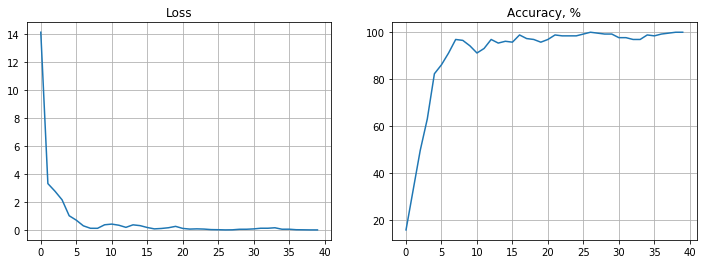

In [14]:
plot_loss_and_acc(train_loss, train_accuracy)

In [15]:
a, b = evaluate_net(model_resnet, X_train, y_train)

In [16]:
np.mean(a)

1.0

In [17]:
a, b = evaluate_net(model_resnet, X_test, y_test)

In [18]:
np.mean(a)

0.8733333468437194